In [22]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, DataStructs, rdmolops, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import Draw
from rdkit import RDLogger
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from itertools import product
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import py3Dmol
import mols2grid
#from pymol import cmd
from rdkit.Chem import PandasTools

RDLogger.DisableLog('rdApp.*')

In [1]:
!wsl ./smina.static --help


Input:
  -r [ --receptor ] arg         rigid part of the receptor (PDBQT)
  --flex arg                    flexible side chains, if any (PDBQT)
  -l [ --ligand ] arg           ligand(s)
  --flexres arg                 flexible side chains specified by comma 
                                separated list of chain:resid or 
                                chain:resid:icode
  --flexdist_ligand arg         Ligand to use for flexdist
  --flexdist arg                set all side chains within specified distance 
                                to flexdist_ligand to flexible

Search space (required):
  --center_x arg                X coordinate of the center
  --center_y arg                Y coordinate of the center
  --center_z arg                Z coordinate of the center
  --size_x arg                  size in the X dimension (Angstroms)
  --size_y arg                  size in the Y dimension (Angstroms)
  --size_z arg                  size in the Z dimension (Angstroms)
  --autobox_ligan

In [3]:
# Initiate smiles for the ligand from PDB (3EJ CACTVS)
mmp13_ligand_smiles = "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"
mmp13_ligand_mol = Chem.MolFromSmiles(mmp13_ligand_smiles)
mmp13_ligand_mol

# Calculate Tanimoto Sim score
mmp13_ligand_fp = AllChem.GetMorganFingerprintAsBitVect(mmp13_ligand_mol, 2, nBits=2048)

def compute_similarity(mol):
    if mol is None:
        return np.nan
    mol_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    return DataStructs.TanimotoSimilarity(mmp13_ligand_fp, mol_fp)


In [4]:
docking_library = pd.read_csv("docking_library.csv", sep = ',')

# Convert smiles in library to RDKit Molecules
docking_library["Mol"] = docking_library["smiles"].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

# Calc sim scores
docking_library["Tanimoto_Similarity"] = docking_library["Mol"].apply(compute_similarity)

docking_library

broad_id                pert_iname  qc_incompatible  \
0    BRD-K45875383-001-01-2                    XBD173              0.0   
1    BRD-K47710001-001-03-7               zopolrestat              0.0   
2    BRD-K71266197-236-03-9                 PSB-06126              0.0   
3    BRD-K19203487-001-01-4                    SPP301              0.0   
4    BRD-K90747162-001-02-9                      KG-5              0.0   
..                      ...                       ...              ...   
231  BRD-K00004617-001-01-9         imidazoacridinone              0.0   
232  BRD-K00003506-001-01-9                 risdiplam              0.0   
233  BRD-K00003427-001-01-9                ilaprazole              0.0   
234  BRD-K00003219-001-01-9  deferasirox-iron-chelate              0.0   
235            MMP13_Ligand                       NaN              NaN   

     purity     vendor    catalog_no  \
0     99.75  MedChemEx      HY-15527   
1     99.72      Sigma  MFCD00865476   
2     99.70     Tocris          2574   
3     99.69  MedChemEx      HY-15195   
4     99.59     Tocris          5260   
..      ...        ...           ...   
231   57.63      Sigma       SML0465   
232   56.36  MedChemEx     HY-109101   
233   41.08  MedChemEx     HY-101664   
234    0.45  MedChemEx      HY-16564   
235     NaN        NaN           NaN   

                                           vendor_name  expected_mass  \
0                                             Emapunil        401.185   
1    (4-oxo-3-{[5-(trifluoromethyl)-1,3-benzothiazo...        419.055   
2                                            PSB 06126        444.078   
3                                            Avosentan        479.126   
4                                                 KG 5        459.109   
..                                                 ...            ...   
231  5-{[2-(diethylamino)ethyl]amino}-8-hydroxy-6H-...        350.174   
232                                          Risdiplam        401.196   
233                                         Ilaprazole        366.115   
234                         Deferasirox (Fe3+ chelate)        427.026   
235                                                NaN            NaN   

                                                smiles  \
0    CCN(Cc1ccccc1)C(=O)Cn1c2nc(ncc2n(C)c1=O)-c1ccccc1   
1    OC(=O)Cc1nn(Cc2nc3cc(ccc3s2)C(F)(F)F)c(=O)c2cc...   
2    Nc1c2C(=O)c3ccccc3C(=O)c2c(Nc2cccc3ccccc23)cc1...   
3    COc1ccccc1Oc1c(NS(=O)(=O)c2ccc(C)cn2)nc(nc1OC)...   
4    CSc1nc(N)cc(Oc2ccc(cc2)-c2nnc(Nc3cccc(c3)C(F)(...   
..                                                 ...   
231          CCN(CC)CCNc1ccc2ncn3c2c1c(=O)c1cc(O)ccc31   
232  Cc1cn2nc(cc(C)c2n1)-c1cc(=O)n2cc(ccc2n1)N1CCNC...   
233  COc1ccnc(C[S@@](=O)c2nc3ccc(cc3[nH]2)-n2cccc2)...   
234  OC(=O)c1ccc(cc1)-n1nc-2nc1-c1ccccc1O[Fe]Oc1ccc...   
235  OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(...   

                        InChIKey  ...                 FP_Array    PC1_fp  \
0    NBMBIEOUVBHEBM-UHFFFAOYSA-N  ...  [0. 0. 0. ... 0. 0. 0.] -3.095563   
1    BCSVCWVQNOXFGL-UHFFFAOYSA-N  ...  [0. 0. 0. ... 0. 0. 0.] -3.914286   
2    ZHQRPIRGSWEALJ-UHFFFAOYSA-N  ...  [0. 1. 0. ... 0. 0. 0.] -2.863828   
3    YBWLTKFZAOSWSM-UHFFFAOYSA-N  ...  [0. 0. 0. ... 0. 0. 0.] -4.605148   
4    CMYHZFCJPORPHY-UHFFFAOYSA-N  ...  [0. 0. 0. ... 0. 0. 0.] -3.659626   
..                           ...  ...                      ...       ...   
231  CUNDRHORZHFPLY-UHFFFAOYSA-N  ...  [0. 0. 0. ... 0. 0. 0.] -1.842979   
232  ASKZRYGFUPSJPN-UHFFFAOYSA-N  ...  [0. 0. 0. ... 0. 0. 0.] -2.338872   
233  HRRXCXABAPSOCP-AREMUKBSSA-N  ...  [0. 0. 0. ... 0. 0. 0.] -3.867298   
234  XLHBYAVMDSNIEM-UHFFFAOYSA-L  ...  [0. 0. 0. ... 0. 0. 0.] -2.389562   
235                          NaN  ...  [0. 0. 0. ... 0. 0. 0.] -3.754004   

       PC2_fp  Fingerprint_Cluster  PC1_desc  PC2_desc  Descriptor_Cluster  \
0    2.012310                    0  0.629000  0.142115                   1   
1    3

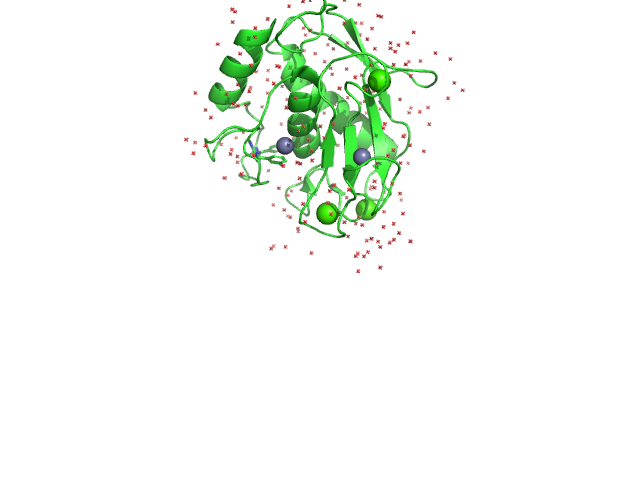

In [5]:
from pymol import cmd
from IPython.display import Image

cmd.reinitialize()
cmd.fetch("3KEJ")
cmd.orient("3KEJ")
cmd.rotate("z", "270")

# Remove one chain (e.g., chain B)
cmd.remove("chain B")

# Save and display the cleaned-up image
cmd.png("image.png")
Image(filename="image.png", unconfined=True)


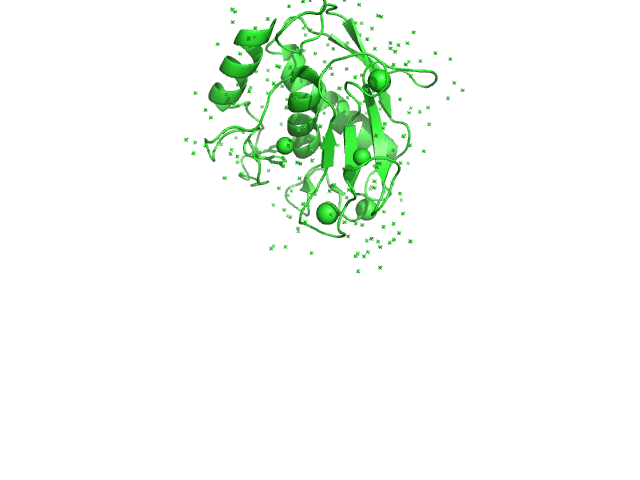

In [6]:
cmd.util.cbc()
cmd.png("image.png")
Image(filename = "image.png", unconfined=True)

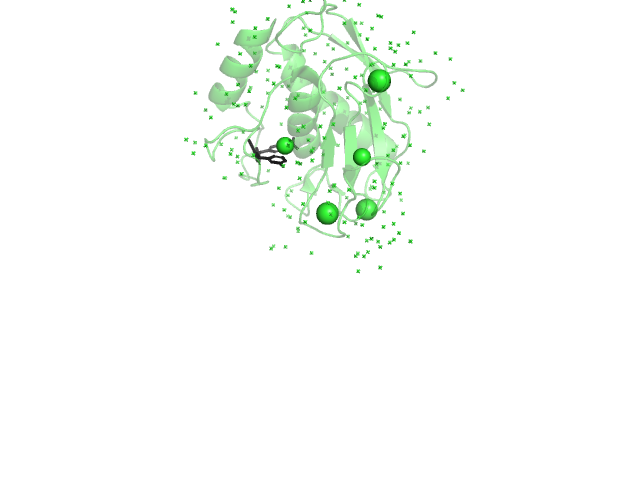

In [7]:
cmd.color("black","organic")
cmd.set("cartoon_transparency",0.5)
cmd.png("image.png")
Image(filename = "image.png", unconfined=True)

In [8]:
#Now we need to split the above into a ligand and a receptor file
cmd.select("3KEJ-ligand", "resn 3EJ") #Create a selection called 6ME7-ligand from the ligand
cmd.select("3KEJ-receptor", "3KEJ and not 3KEJ-ligand")  #Select all that is not the ligand, and make that the protein
cmd.save("3KEJ-ligand.pdb", "3KEJ-ligand")
cmd.save("3KEJ-receptor.pdb", "3KEJ-receptor")

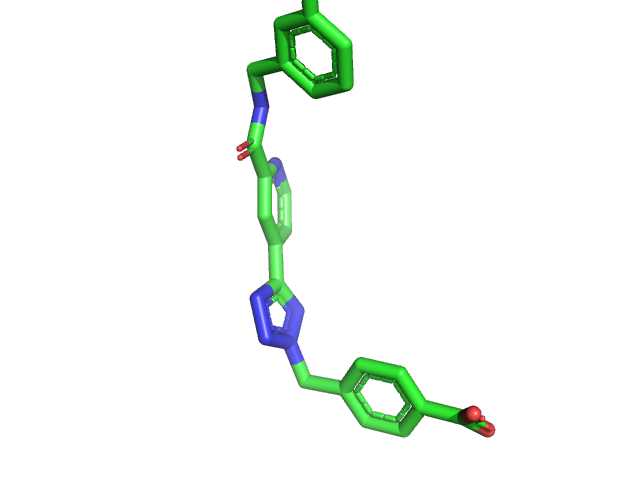

In [9]:
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("3KEJ-ligand.pdb")
cmd.png("ligand.png")
Image(filename = "ligand.png", unconfined=True)

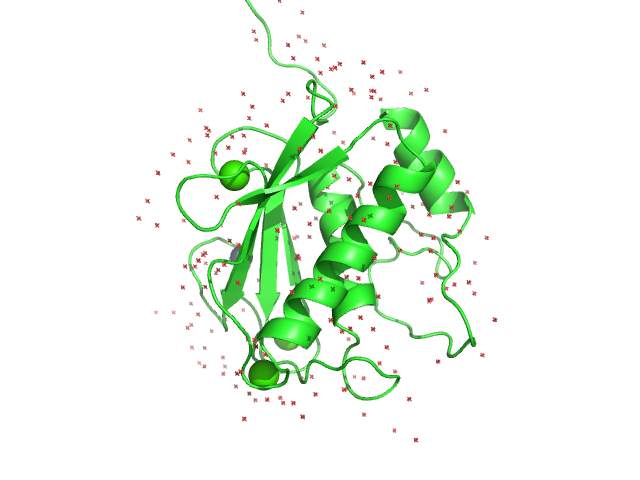

In [10]:
#Now the receptor
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("3KEJ-receptor.pdb")
cmd.orient("3KEJ-receptor")
cmd.rotate("z","270")
cmd.png("receptor.png")
Image(filename = "receptor.png", unconfined=True)

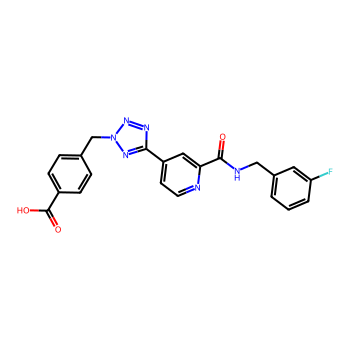

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw

size=(350,350)

lig = Chem.MolFromSmiles("OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1")
img = Draw.MolToImage(lig, size=size)
img
# MolToMPL no longer supported as a function, had to change to Draw.MolToImage

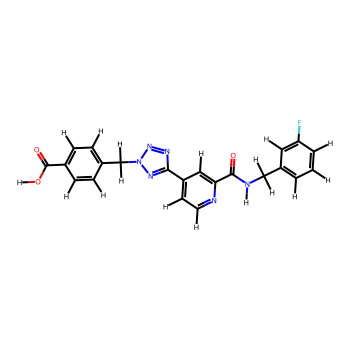

In [12]:
ligH = Chem.AddHs(lig, addCoords=True) #We need to add hydrogens to the new ligand
imgH = Draw.MolToImage(ligH, size=size)
imgH

In [13]:
#Now to minimize to a 3D structure using the AllChem Module
import py3Dmol
from rdkit.Chem import AllChem
AllChem.EmbedMolecule(ligH)
AllChem.MMFFOptimizeMolecule(ligH)


#Display the result using py3Dmol
mblock = Chem.MolToMolBlock(ligH)

view = py3Dmol.view(data=mblock, style={"stick": {}, "sphere": {"scale": 0.3}})
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [17]:
#Allright now we have the molecule converted to 3D - sae it as a new sdf
file = Chem.SDWriter('newligand.sdf') #create the file
file.write(ligH) #write the 3d ligand to the file

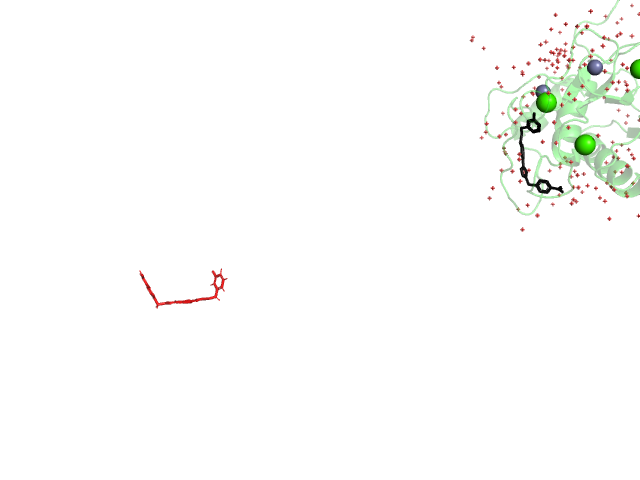

In [18]:
#Lets check the new ligand - so the new ligand should be assigned random coordinates in space. If we load this new one into our previous PDB file, we will see it's somewhere random
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("3KEJ-receptor.pdb")
cmd.load("3KEJ-ligand.pdb")
cmd.color("black","3KEJ-ligand")
cmd.load("newligand.sdf")
cmd.color("red","newligand")
cmd.set("cartoon_transparency",0.6)
cmd.select("ligands", "organic")
cmd.zoom("ligands")
#cmd.rotate("z","270")
cmd.png("receptor.png")
Image(filename = "receptor.png", unconfined=True)

In [20]:
#OK - so now we have the ligand and receptor in separate files, lets see if smina can redock the ligand into the receptor
#The autobox command tells smina to focus docking around the cognate ligand and create a "box"
!wsl ./smina.static -r  3KEJ-receptor.pdb -l newligand.sdf --autobox_ligand 3KEJ-ligand.pdb -o 3KEJ-ligand-poses.sdf

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -1130469000

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


In [4]:
#Ok lets look at the sdf that was generated
from rdkit.Chem import PandasTools

dockedposes = PandasTools.LoadSDF("3KEJ-ligand-poses.sdf")

minimizedAffinity ID                                              ROMol
0         -14.53489     <rdkit.Chem.rdchem.Mol object at 0x0000011A8BF...
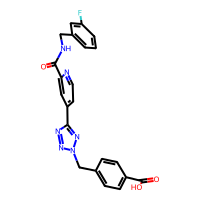

In [22]:
dockedposes

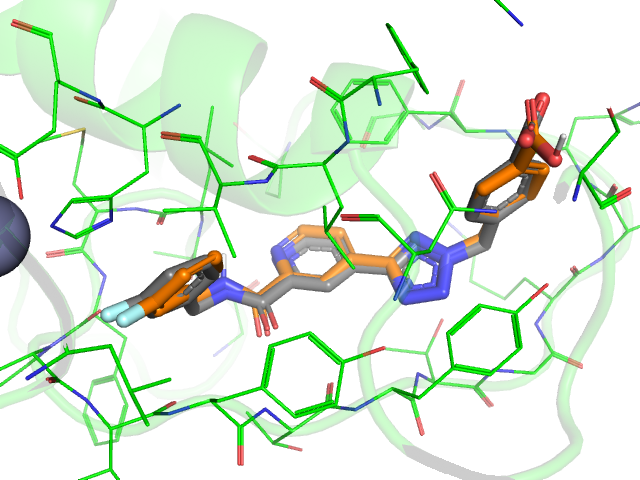

In [41]:
#Wipe the memory and load into the workspace
cmd.reinitialize()
cmd.load("3KEJ-receptor.pdb")
cmd.load("3KEJ-ligand.pdb")
cmd.load("3KEJ-ligand-poses.sdf")


cmd.color("green","3KEJ-receptor") #color the protein cyan
cmd.color("grey", "3KEJ-ligand") #Color the original pose grey
cmd.color("orange", "3KEJ-ligand-poses")

#We will cerate a selection sphere around the ligand and show the residues
cmd.select("pocketresidues", "byres (all within 5 of 3KEJ-ligand)&polymer.protein")
cmd.show("line","pocketresidues")
cmd.set("ray_shadow",0)
cmd.set("cartoon_transparency", 0.8)
cmd.util.cnc()
cmd.zoom("pocketres") #zoom in on only the pocket
cmd.rotate("z","90")
cmd.rotate("x","25")
cmd.zoom("pocketres or 3KEJ-ligand or 3KEJ-ligand-poses", buffer = -5)
cmd.hide("everything", "resn HOH")


camera = cmd.get_view() #save the camera viewpoint sometimes it can get reset so we will enforce the same

#display the best pose
camera = cmd.get_view()
cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

In [42]:
docking_library["canonical_smiles"] = docking_library["smiles"].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x), canonical=True))

In [43]:
from rdkit import DataStructs

fpgen = AllChem.GetMorganGenerator()
query = Chem.MolFromSmiles('OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1')
queryfp = fpgen.GetFingerprint(query)

smiles = list(docking_library['canonical_smiles'])
sim=[]
for x in smiles:
  target = Chem.MolFromSmiles(x)
  targetfp = fpgen.GetFingerprint(target)
  s=DataStructs.TanimotoSimilarity(targetfp,queryfp)
  sim.append(s)


docking_library["Sim"]=sim
docking_library=docking_library.sort_values("Sim", ascending=False)
docking_library

broad_id   pert_iname  qc_incompatible  purity     vendor  \
235            MMP13_Ligand          NaN              NaN     NaN        NaN   
177  BRD-K52087522-300-01-2    YM-244769              0.0   94.40     Tocris   
92   BRD-K00003255-001-01-9  acebilustat              0.0   97.48  MedChemEx   
30   BRD-K00003140-001-01-9   hPGDS-IN-1              0.0   98.83  MedChemEx   
151  BRD-K89517477-001-01-4    TC-S-7004              0.0   95.75     Tocris   
..                      ...          ...              ...     ...        ...   
64   BRD-K72063794-003-02-9        VU591              0.0   98.13     Tocris   
139  BRD-K78318619-001-02-7   PF-4981517              0.0   96.16    Selleck   
213  BRD-K58726989-001-02-7   HTH-01-015              0.0   90.24    ApexBio   
197  BRD-K02943813-001-02-9    dasabuvir              0.0   92.69  MedChemEx   
76   BRD-K00003097-001-01-9  PF-05180999              0.0   97.87  MedChemEx   

    catalog_no           vendor_name  expected_mass  \
235        NaN                   NaN            NaN   
177       4544             YM 244769        443.165   
92    HY-17625           Acebilustat        481.200   
30    HY-12791            hPGDS-IN-1        416.160   
151       5088             TC-S 7004        497.066   
..         ...                   ...            ...   
64        4197  VU 591 hydrochloride        368.087   
139      S2921            PF-4981517        456.275   
213      A8890            HTH-01-015        468.239   
197   HY-13998             Dasabuvir        493.167   
76   HY-111371           PF-05180999        414.153   

                                                smiles  \
235  OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(...   
177  Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...   
92   [H][C@]12CN(Cc3ccc(cc3)C(O)=O)[C@]([H])(CN1Cc1...   
30   CC(C)(O)c1nc(no1)-c1cccc(CNC(=O)c2cnc(nc2)-c2c...   
151  COc1ncc2cc(C(=O)Nc3cc(ccc3Cl)C(=O)NCc3cccc(Cl)...   
..                                                 ...   
64   [O-][N+](=O)c1ccc2nc(COCc3nc4ccc(cc4[nH]3)[N+]...   
139  Cc1ccc(cc1)-c1c(cnn1C)-c1nn(C)c2ncnc(N3CC[C@@H...   
213  CN1c2cc3ccccc3cc2C(=O)N(C)c2c(C)nc(Nc3cnn(c3)C...   
197  COc1c(cc(cc1C(C)(C)C)-n1ccc(=O)[nH]c1=O)-c1ccc...   
76   Cc1nc(-c2cnn(C)c2-c2ccc(cn2)C(F)(F)F)c2c(ncnn1...   

                        InChIKey  ...    PC2_fp Fingerprint_Cluster  PC1_desc  \
235                          NaN  ...  4.319927                   0  0.807253   
177  JZMLHJRKSJXARY-UHFFFAOYSA-N  ...  2.869808                   0  0.617682   
92   GERJIEKMNDGSCS-DQEYMECFSA-N  ...  2.528964                   0  0.604079   
30   VJCLAPUACUQZOV-UHFFFAOYSA-N  ...  4.447615                   0  0.721303   
151  CQKBSRPVZZLCJE-UHFFFAOYSA-N  ...  4.010985                   0  0.648716   
..                           ...  ...       ...                 ...       ...   
64   ZQPXNYLXYNRFNP-UHFFFAOYSA-N  ...  0.181929                   0  0.671464   
139  WDWIMDKOXZZYHH-FQEVSTJZSA-N  ...  7.551678                   0  0.609409   
213  CHSDJDLAKKAWCI-UHFFFAOYSA-N  ...  6.958484                   0  0.624355   
197  NBRBXGKOEOGLOI-UHFFFAOYSA-N  ...  4.037070                   0  0.635766   
76   CLGCHUKGBICQTE-UHFFFAOYSA-N  ...  6.173713                   0  0.626311   

     PC2_desc  Descriptor_Cluster  PC1_desc_cluster1  PC2_desc_cluster1  \
235 -0.105299                   1           0.351077           0.200216   
177  0.146332                   1          -0.051267           0.226217   
92   0.107476                   1          -0.006839           0.220197   
30  -0.015149                   1           0.238297           0.159782   
151 -0.014335                   1           0.192498           0.156933   
..        ...                 ...                ...                ...   
64   0.011251                   1           0.224317           0.161025   
139  0.155008                   1          -0.008920           0.136407   
213  0.079516                   1           0.080773

In [44]:
from rdkit.Chem.rdMolDescriptors import CalcExactMolWt

no_salt_smile=[]
for x in smiles:
  mol = Chem.MolFromSmiles(x)
  mol = Chem.rdmolops.RemoveHs(mol)
  fragments = Chem.GetMolFrags(mol, asMols=True)
  desalted = max(fragments, key=lambda m: CalcExactMolWt(m))
  canonical = Chem.MolToSmiles(mol, canonical=True)
  no_salt_smile.append(canonical)

docking_library["Unsalted"] = no_salt_smile
docking_library

unsalted=list(docking_library['Unsalted'])
space_model=[]
for y in unsalted:
  lig = Chem.MolFromSmiles(y)
  lig = Chem.AddHs(lig, addCoords=True)
  AllChem.EmbedMolecule(lig)
  AllChem.MMFFOptimizeMolecule(lig)
  space_model.append(lig)

docking_library["Space_Model"] = space_model
docking_library

broad_id   pert_iname  qc_incompatible  purity     vendor  \
235            MMP13_Ligand          NaN              NaN     NaN        NaN   
177  BRD-K52087522-300-01-2    YM-244769              0.0   94.40     Tocris   
92   BRD-K00003255-001-01-9  acebilustat              0.0   97.48  MedChemEx   
30   BRD-K00003140-001-01-9   hPGDS-IN-1              0.0   98.83  MedChemEx   
151  BRD-K89517477-001-01-4    TC-S-7004              0.0   95.75     Tocris   
..                      ...          ...              ...     ...        ...   
64   BRD-K72063794-003-02-9        VU591              0.0   98.13     Tocris   
139  BRD-K78318619-001-02-7   PF-4981517              0.0   96.16    Selleck   
213  BRD-K58726989-001-02-7   HTH-01-015              0.0   90.24    ApexBio   
197  BRD-K02943813-001-02-9    dasabuvir              0.0   92.69  MedChemEx   
76   BRD-K00003097-001-01-9  PF-05180999              0.0   97.87  MedChemEx   

    catalog_no           vendor_name  expected_mass  \
235        NaN                   NaN            NaN   
177       4544             YM 244769        443.165   
92    HY-17625           Acebilustat        481.200   
30    HY-12791            hPGDS-IN-1        416.160   
151       5088             TC-S 7004        497.066   
..         ...                   ...            ...   
64        4197  VU 591 hydrochloride        368.087   
139      S2921            PF-4981517        456.275   
213      A8890            HTH-01-015        468.239   
197   HY-13998             Dasabuvir        493.167   
76   HY-111371           PF-05180999        414.153   

                                                smiles  \
235  OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(...   
177  Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...   
92   [H][C@]12CN(Cc3ccc(cc3)C(O)=O)[C@]([H])(CN1Cc1...   
30   CC(C)(O)c1nc(no1)-c1cccc(CNC(=O)c2cnc(nc2)-c2c...   
151  COc1ncc2cc(C(=O)Nc3cc(ccc3Cl)C(=O)NCc3cccc(Cl)...   
..                                                 ...   
64   [O-][N+](=O)c1ccc2nc(COCc3nc4ccc(cc4[nH]3)[N+]...   
139  Cc1ccc(cc1)-c1c(cnn1C)-c1nn(C)c2ncnc(N3CC[C@@H...   
213  CN1c2cc3ccccc3cc2C(=O)N(C)c2c(C)nc(Nc3cnn(c3)C...   
197  COc1c(cc(cc1C(C)(C)C)-n1ccc(=O)[nH]c1=O)-c1ccc...   
76   Cc1nc(-c2cnn(C)c2-c2ccc(cn2)C(F)(F)F)c2c(ncnn1...   

                        InChIKey  ...  PC1_desc  PC2_desc Descriptor_Cluster  \
235                          NaN  ...  0.807253 -0.105299                  1   
177  JZMLHJRKSJXARY-UHFFFAOYSA-N  ...  0.617682  0.146332                  1   
92   GERJIEKMNDGSCS-DQEYMECFSA-N  ...  0.604079  0.107476                  1   
30   VJCLAPUACUQZOV-UHFFFAOYSA-N  ...  0.721303 -0.015149                  1   
151  CQKBSRPVZZLCJE-UHFFFAOYSA-N  ...  0.648716 -0.014335                  1   
..                           ...  ...       ...       ...                ...   
64   ZQPXNYLXYNRFNP-UHFFFAOYSA-N  ...  0.671464  0.011251                  1   
139  WDWIMDKOXZZYHH-FQEVSTJZSA-N  ...  0.609409  0.155008                  1   
213  CHSDJDLAKKAWCI-UHFFFAOYSA-N  ...  0.624355  0.079516                  1   
197  NBRBXGKOEOGLOI-UHFFFAOYSA-N  ...  0.635766  0.017608                  1   
76   CLGCHUKGBICQTE-UHFFFAOYSA-N  ...  0.626311  0.130315                  1   

     PC1_desc_cluster1  PC2_desc_cluster1  Sub_Cluster  \
235           0.351077           0.200216            4   
177          -0.051267           0.226217            4   
92           -0.006839           0.220197            4   
30            0.238297           0.159782            4   
151           0.192498           0.156933            4   
..                 ...                ...          ...   
64            0.224317           0.161025            4   
139          -0.008920           0.136407            4   
213           0.080773           0.167047            4   
197           0.158879           0.170983            4   
76            0.046023           0.103350            4   

                                      cano

In [45]:
PandasTools.WriteSDF(docking_library, out="3KEJ_smina.sdf",
                     molColName='Space_Model',
                     idName='broad_id',
                     properties=None,
                     allNumeric=False,
                     forceV3000=False)

In [106]:
!wsl ./smina.static -r  3KEJ-receptor.pdb -l 3KEJ_smina.sdf --autobox_ligand 3KEJ-ligand.pdb -o 3KEJ_smina_results.sdf  --exhaustiveness 5 --num_modes 1 --cpu 8

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 615588190

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


In [40]:
#now load the results
myresults = PandasTools.LoadSDF("3KEJ_smina_results.sdf")



myresults[myresults["ID"] == "BRD-K19002914-001-01-3"]

minimizedAffinity                      ID  \
56         -11.43799  BRD-K19002914-001-01-3   

                                                ROMol  
56  <rdkit.Chem.rdchem.Mol object at 0x000001F3521...

In [38]:
merged=docking_library.merge(myresults, left_on= "broad_id", right_on="ID")
merged=merged[['broad_id','minimizedAffinity']] #We can clean up a few of the columns

merged.to_csv('myresults.csv')

merged['minimizedAffinity'].astype(float)
# Convert 'minimizedAffinity' to float
merged['minimizedAffinity'] = pd.to_numeric(merged['minimizedAffinity'], errors='coerce')


merged=merged.sort_values('minimizedAffinity', ascending=True)


top_picks = merged.head(30)

top_picks

broad_id  minimizedAffinity
76   BRD-K00003097-001-01-9          -14.45168
175  BRD-K97452254-001-01-3          -12.85738
5    BRD-K70301465-001-05-9          -12.85388
219  BRD-K26122255-001-01-7          -11.93361
119  BRD-K85402309-406-01-8          -11.93030
193  BRD-K00003340-300-01-9          -11.92843
4    BRD-K90747162-001-02-9          -11.71295
138  BRD-K00004601-001-01-9          -11.63834
181  BRD-K67262033-001-01-0          -11.62769
16   BRD-K68453341-001-01-1          -11.55530
151  BRD-K89517477-001-01-4          -11.53147
130  BRD-K00004638-001-01-9          -11.50301
124  BRD-K60659193-001-02-8          -11.49386
121  BRD-K19002914-001-01-3          -11.43799
67   BRD-K27182532-001-02-3          -11.34483
187  BRD-K00003397-001-01-9          -11.34295
10   BRD-K16472653-001-02-4          -11.33939
198  BRD-K21865955-003-01-5          -11.30663
132  BRD-K11773281-001-02-0          -11.29755
226  BRD-K81958169-001-01-1          -11.29372
62   BRD-K34185671-001-02-8          -11.05324
148  BRD-K56405753-001-03-9          -11.01139
194  BRD-K31309378-001-02-3          -10.95300
164  BRD-K31553034-001-03-0          -10.94633
53   BRD-K11911061-003-12-9          -10.90719
172  BRD-K64785675-001-04-0          -10.87816
142  BRD-K88854110-001-01-5          -10.87462
111  BRD-K37237504-001-04-9          -10.82636
90   BRD-K00004306-001-01-9          -10.82439
118  BRD-K94176593-362-10-9          -10.66063

In [39]:
pd.set_option('display.max_columns', 300)

docking_names = list(top_picks['broad_id'])

docking_names.append('MMP13_Ligand')

docking_library[docking_library['broad_id'].isin(docking_names)]

broad_id    pert_iname  qc_incompatible  purity     vendor  \
4    BRD-K90747162-001-02-9          KG-5              0.0   99.59     Tocris   
5    BRD-K70301465-001-05-9     ibrutinib              0.0   99.58    Selleck   
10   BRD-K16472653-001-02-4     SirReal-2              0.0   99.29     Tocris   
16   BRD-K68453341-001-01-1       GS-6201              0.0   99.12     Tocris   
53   BRD-K11911061-003-12-9     GR-127935              0.0   98.30     Tocris   
62   BRD-K34185671-001-02-8       AMG-517              0.0   98.16    Selleck   
67   BRD-K27182532-001-02-3     metatinib              0.0   98.07    Selleck   
76   BRD-K00003097-001-01-9   PF-05180999              0.0   97.87  MedChemEx   
90   BRD-K00004306-001-01-9  edaglitazone              0.0   97.51     Tocris   
111  BRD-K37237504-001-04-9     CEP-33779              0.0   97.00  MedChemEx   
118  BRD-K94176593-362-10-9       TWS-119              0.0   96.85     Tocris   
119  BRD-K85402309-406-01-8     dovitinib              0.0   96.83    Selleck   
121  BRD-K19002914-001-01-3        EED226              0.0   96.75  MedChemEx   
124  BRD-K60659193-001-02-8     CVT-10216              0.0   96.71     Tocris   
130  BRD-K00004638-001-01-9   PF-06273340              0.0   96.55      Sigma   
132  BRD-K11773281-001-02-0       4SC-202              0.0   96.41  MedChemEx   
138  BRD-K00004601-001-01-9        HC-070              0.0   96.18  MedChemEx   
142  BRD-K88854110-001-01-5    taprenepag              0.0   96.08  MedChemEx   
148  BRD-K56405753-001-03-9       MK-2461              0.0   95.82  MedChemEx   
151  BRD-K89517477-001-01-4     TC-S-7004              0.0   95.75     Tocris   
164  BRD-K31553034-001-03-0    zibotentan              0.0   95.30    Selleck   
172  BRD-K64785675-001-04-0     TG100-115              0.0   94.74    Selleck   
175  BRD-K97452254-001-01-3       AMG-925              0.0   94.57  MedChemEx   
181  BRD-K67262033-001-01-0       TAK-593              0.0   94.10  MedChemEx   
187  BRD-K00003397-001-01-9       MK-8617              0.0   93.74  MedChemEx   
193  BRD-K00003340-300-01-9        JPH203              0.0   92.99  MedChemEx   
194  BRD-K31309378-001-02-3     lucitanib              0.0   92.94  MedChemEx   
198  BRD-K21865955-003-01-5        NS-018              0.0   92.62  MedChemEx   
219  BRD-K26122255-001-01-7        VLX600              0.0   87.51    Enamine   
226  BRD-K81958169-001-01-1        AZ5104              0.0   79.95    Selleck   
235            MMP13_Ligand           NaN              NaN     NaN        NaN   

       catalog_no                                        vendor_name  \
4            5260                                               KG 5   
5           S2680                                          Ibrutinib   
10           5457                                           SirReal2   
16           4727  3-ethyl-1-propyl-8-{1-[3-(trifluoromethyl)benz...   
53           1477                            GR 127935 hydrochloride   
62          S7115                                            AMG-517   
67          S2201                                         BMS-794833   
76      HY-111371                                        PF-05180999   
90           4784                                       Edaglitazone   
111      HY-15343                                          CEP-33779   
118          3835                                            TWS 119   
119         S7765                         Dovitinib (TKI258) Lactate   
121     HY-101117                                             EED226   
124          5164                                          CVT 10216   
130        PZ0254  N-[5-[2-amino-7-(2-hydroxy-1,1-dimethyl-ethyl)...   
132     HY-16012A                                4SC-202 (free base)   
138     HY-112302                                             HC-070   
142      HY-14899                                         Taprenepag   
148      HY-50703                                         

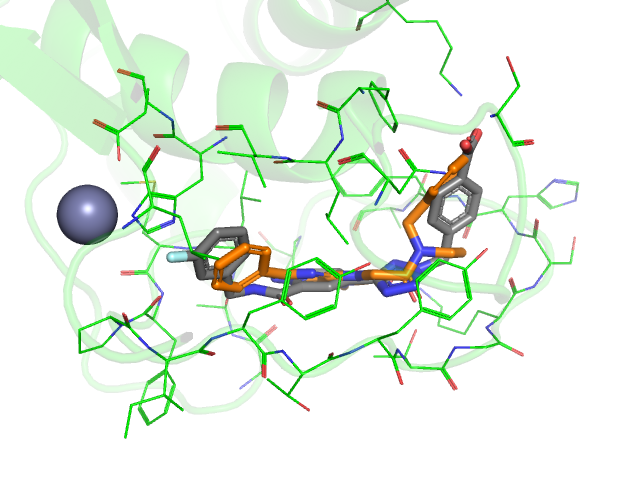

In [19]:
#Wipe the memory and load into the workspace
cmd.reinitialize()
cmd.load("3KEJ-receptor.pdb")
cmd.load("3KEJ-ligand.pdb")
cmd.load("3KEJ_smina_results.sdf")


cmd.color("green","3KEJ-receptor") #color the protein cyan
cmd.color("grey", "3KEJ-ligand") #Color the original pose grey
cmd.color("orange", "3KEJ_smina_results")

#We will cerate a selection sphere around the ligand and show the residues
cmd.select("pocketresidues", "byres (all within 5 of 3KEJ-ligand)&polymer.protein")
cmd.show("line","pocketresidues")
cmd.set("ray_shadow",0)
cmd.set("cartoon_transparency", 0.8)
cmd.util.cnc()
cmd.zoom("pocketres") #zoom in on only the pocket
cmd.rotate("z","90")
camera = cmd.get_view() #save the camera viewpoint sometimes it can get reset so we will enforce the same

#ok lets split the states and show the first docked ligand
cmd.split_states("3KEJ_smina_results")
cmd.remove("3KEJ_smina_results")
cmd.hide("stick","BRD*")
cmd.show("stick", "MMP13_Ligand")
cmd.hide("stick","BRD-K72063794-003-02-9")
cmd.hide("everything", "resn HOH")
cmd.zoom("pocketres or 3KEJ-ligand or 3KEJ_smina_results", buffer = -2)


cmd.png("pose1.png")
cmd.save("pose1.pdb")
Image(filename = "pose1.png", unconfined=True)





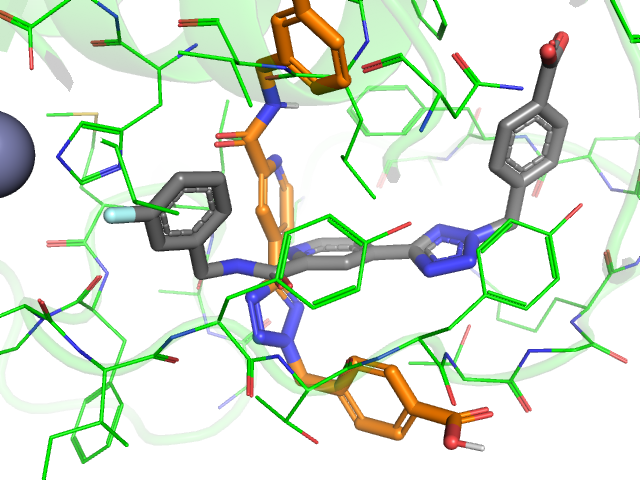

Displayed image: pose_BRD-K00003097-001-01-9.png


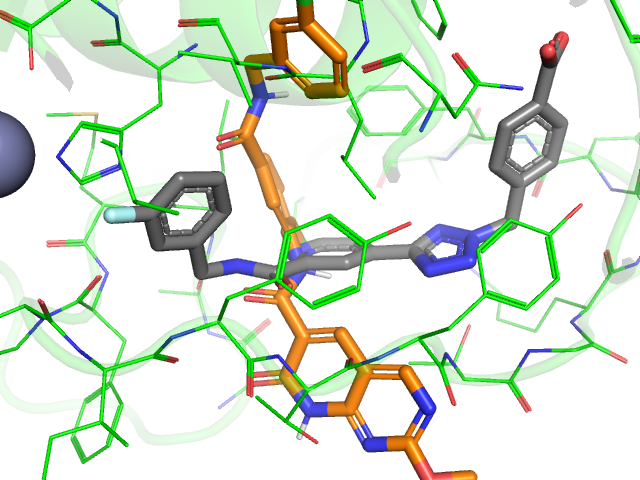

Displayed image: pose_BRD-K97452254-001-01-3.png


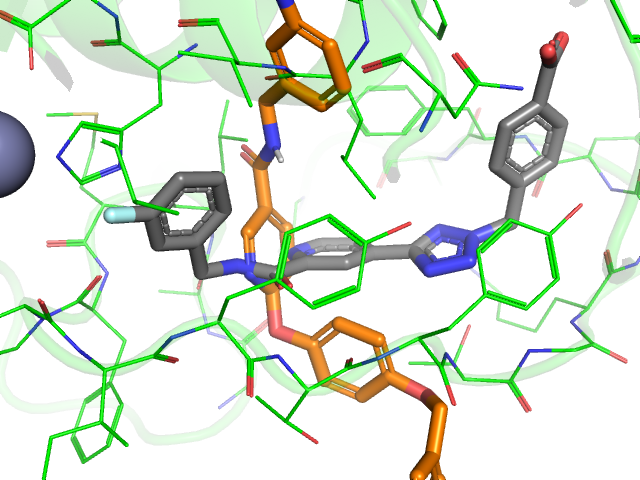

Displayed image: pose_BRD-K70301465-001-05-9.png


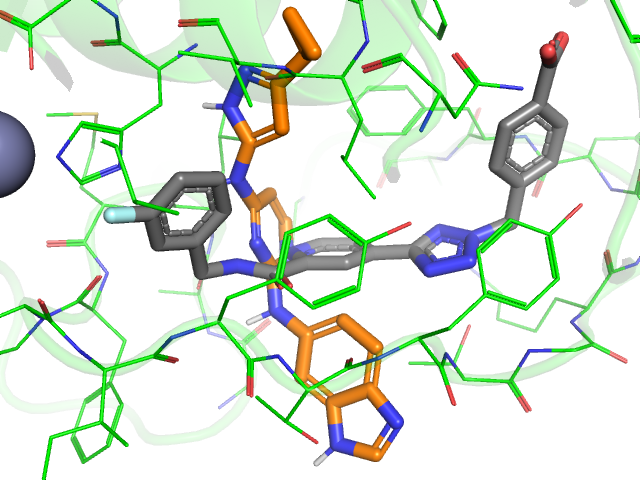

Displayed image: pose_BRD-K26122255-001-01-7.png


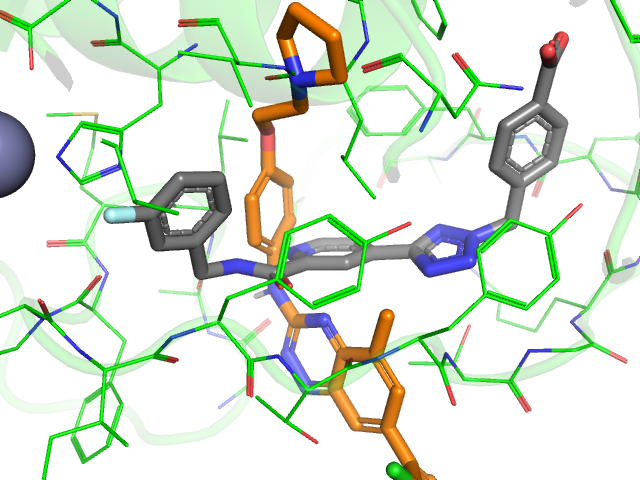

Displayed image: pose_BRD-K85402309-406-01-8.png


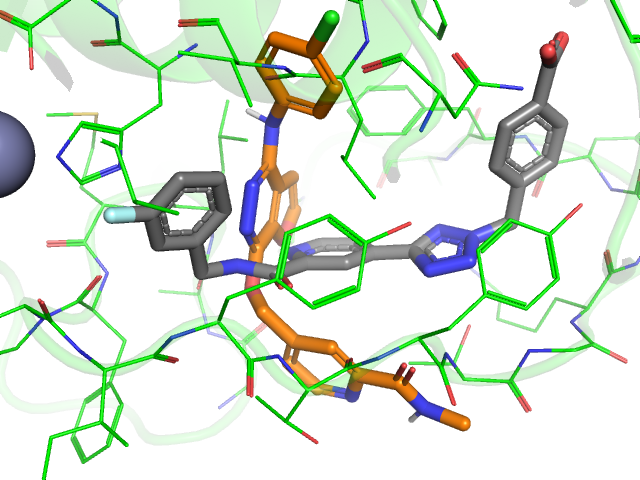

Displayed image: pose_BRD-K00003340-300-01-9.png


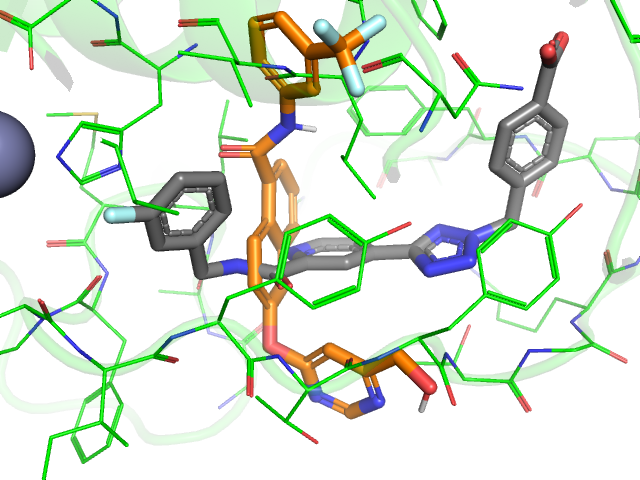

Displayed image: pose_BRD-K90747162-001-02-9.png


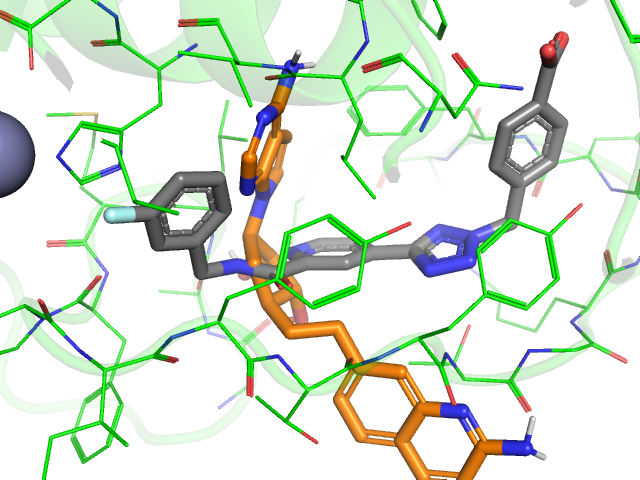

Displayed image: pose_BRD-K00004601-001-01-9.png


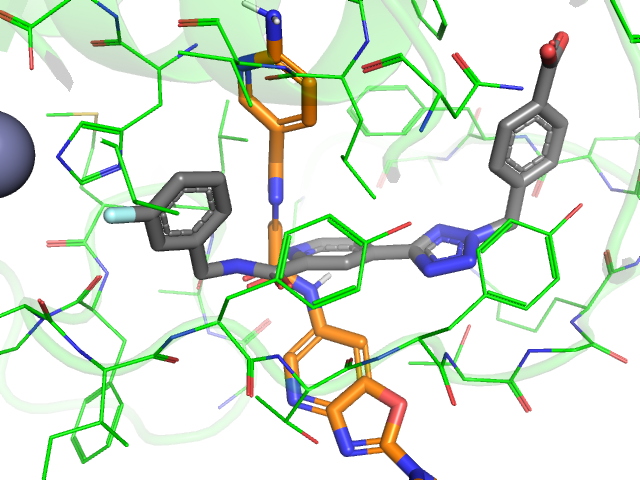

Displayed image: pose_BRD-K67262033-001-01-0.png


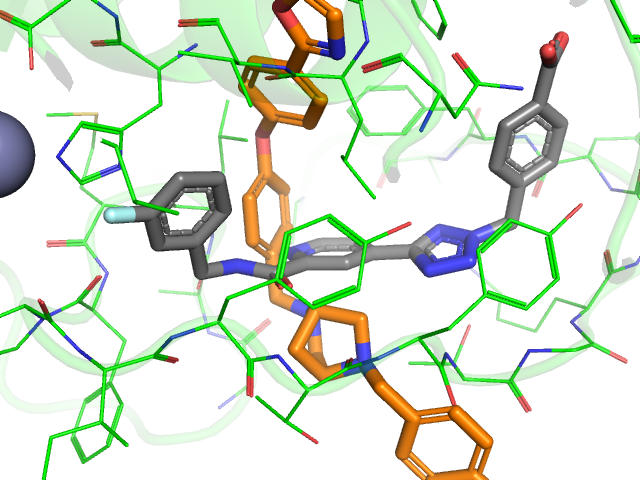

Displayed image: pose_BRD-K68453341-001-01-1.png


In [124]:
# Loop through each broad ID
for index, row in top_picks.iterrows():
    broad_id = row["broad_id"]  # Get ligand ID
    image_name = f"pose_{broad_id}.png"  # Unique file name

    cmd.reinitialize()  # Reset PyMOL session
    cmd.load("3KEJ-receptor.pdb")  
    cmd.load("3KEJ-ligand.pdb")  # Keep the original ligand
    cmd.load("3KEJ_smina_results.sdf")

    # Color settings
    cmd.color("green", "3KEJ-receptor")  # Protein in cyan/green
    cmd.color("grey", "3KEJ-ligand")  # Original ligand in grey
    cmd.color("orange", "3KEJ_smina_results")  # Docked ligands in orange

    # Hide unwanted molecules
    cmd.hide("everything", "resn HOH")  # Hide water molecules

    # Select and zoom into ligand binding pocket
    cmd.select("pocketresidues", "byres (all within 5 of 3KEJ-ligand)&polymer.protein")
    cmd.show("line", "pocketresidues")
    cmd.set("ray_shadow", 0)
    cmd.set("cartoon_transparency", 0.8)
    cmd.util.cnc()
    cmd.zoom("pocketres")
    cmd.rotate("z", "90")

    #cmd.align(broad_id, "3KEJ-ligand") 

    # Split states and show only the current docked ligand while keeping the original ligand
    cmd.split_states("3KEJ_smina_results")

    cmd.remove("3KEJ_smina_results")  # Remove the unsplit state
    cmd.hide("stick", "not (3KEJ-ligand or " + broad_id + ")")  # Keep original ligand AND current docked ligand
    cmd.show("stick", broad_id)  # Show the docked ligand of interest

    # Save and display image
    cmd.png(image_name)
    display(Image(filename=image_name))  # Display in Jupyter Notebook

    print(f"Displayed image: {image_name}")


In [79]:
# Reading in negative controls and making new DF with 50 members

controls = pd.read_csv("negative_controls.csv", sep=';') 
controls.head()


negative_controls = controls.loc[controls["pChEMBL Value"] < 5, ["Molecule ChEMBL ID", "Smiles"]]

negative_controls_50 = negative_controls.sample(n=50, random_state = 77)

negative_controls_50

Molecule ChEMBL ID                                             Smiles
3051      CHEMBL1796281          COc1cccc(CNC(=O)c2ccc(Oc3ccc(C)cc3)cc2)c1
2873       CHEMBL263909       O=C1N/C(=N/c2nsc3ccccc23)S/C1=C\c1ccc(Cl)cc1
3142         CHEMBL1433  C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...
286         CHEMBL90057                  COc1ccc(S(=O)(=O)CC(N)C(=O)NO)cc1
892       CHEMBL4800543  Nc1ccc(-c2cc(Nc3ccccc3)c3c(=O)[nH]c4ccccc4c3c2...
1874      CHEMBL4643922      O=C(Nc1ccc(-c2nc3ccccc3[nH]2)cc1)c1ccc(Br)cc1
2968      CHEMBL4780502  CN(C)c1ccc(Nc2cc(-c3ccccc3)cc3c2c(=O)[nH]c2ccc...
2688      CHEMBL3358158  Cn1ccnc1[C@]1(CNC(=O)c2cc3cc(C(F)(F)F)ccc3o2)N...
3033      CHEMBL4753504  COc1ccc(Nc2cc(-c3ccccc3)cc3c2c(=O)[nH]c2c(OC)c...
1896       CHEMBL318252  Cc1cc(COc2ccc(S(=O)(=O)CC(C=C3CCN(CC(C)C)CC3)N...
2123       CHEMBL574666              N#Cc1cccc(-c2ccc(CCC(O)CC(=O)O)cc2)c1
1129      CHEMBL2164094  CCCNc1nc(NCc2cn(C)cn2)nc(N2CCC[C@@H]2CNS(=O)(=...
3035       CHEMBL161669               O=C1NC(=S)S/C1=C\c1cccc(Oc2ccccc2)c1
517       CHEMBL4742183     O=c1[nH]c2ccccc2c2cc(-c3ccco3)cc(Nc3ccccc3)c12
986        CHEMBL575947        O=C(O)CC(O)CCc1ccc(-c2ccc(Oc3ccccc3)cc2)cc1
3189      CHEMBL1200596                            Oc1c(Cl)cc(Cl)c2cccnc12
1469       CHEMBL551190    CC(C)[C@H](NS(=O)(=O)c1ccc2sc3ccccc3c2c1)C(=O)O
3084      CHEMBL4756447  COc1ccc(Nc2cc(-c3ccccc3)cc3c2c(=O)[nH]c2ccccc2...
2921          CHEMBL151            O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12
520        CHEMBL570310   CC(C)[C@@H](NS(=O)(=O)c1ccc2sc3ccccc3c2c1)C(=O)O
2020       CHEMBL181682             COc1ccc(-c2csc(C(=O)NCCN3CCOCC3)c2)cc1
2849      CHEMBL4640970     Cc1ccc2nc(-c3ccc(NC(=O)CCc4ccccc4)cc3)[nH]c2c1
1958      CHEMBL4641067  Cc1ccc2nc(-c3cccc(NC(=O)CN(C)Cc4ccccn4)c3)[nH]...
1245      CHEMBL1683453  C[C@@H](C[C@@](C)(CS(=O)(=O)N1CCC(CCc2ccc(F)cc...
1302       CHEMBL576762  C[S+]([O-])c1ccc(Oc2ccc(S(=O)(=O)c3ccccc3C(=O)...
3009      CHEMBL4647266        O=C(CCc1ccccc1)Nc1ccc(-c2nc3ccccc3[nH]2)cc1
2935      CHEMBL4635076        O=[N+]([O-])c1ccc(-c2nc3ccc(Br)cc3[nH]2)cc1
1220       CHEMBL468738  CC(C)OC(=O)N1CCC([C@@H](NS(=O)(=O)c2ccc(-c3ccc...
1105       CHEMBL448246                  CCCCCCOc1ccc(C(CC(=O)O)C(N)=O)cc1
3127       CHEMBL473736        Cc1ccc(Cn2nnc3c(=O)n(Cc4cccc(C)c4)cnc32)cc1
2270        CHEMBL99045  Cc1cc(COc2ccc(S(=O)(=O)CC(C=C3CCOCC3)N(O)C=O)c...
1955      CHEMBL4640215  Cc1ccc2oc(-c3ccc(NC(=O)c4ccc([N+](=O)[O-])cc4)...
298        CHEMBL515439    CC(C)[C@H](NS(=O)(=O)c1ccc2oc3ccccc3c2c1)C(=O)O
1986       CHEMBL574444              O=C(O)CC(O)CCc1ccc(-c2cc3ccccc3o2)cc1
2285      CHEMBL1927184           O=C(O)CCCN1C(=O)S/C(=C\C=C\c2ccccc2)C1=O
2442      CHEMBL1939879  Cn1nc(C(=O)NCc2ccc(C(=O)O)cc2)cc1-c1ccc2[nH]c(...
1058      CHEMBL1910469  CC(C)[C@@H](NS(=O)(=O)c1ccc(-c2ccc(OCc3ccccc3C...
2569      CHEMBL1939879  Cn1nc(C(=O)NCc2ccc(C(=O)O)cc2)cc1-c1ccc2[nH]c(...
905        CHEMBL502936            COCc1nnc(NC(=O)c2ccc(NC(=O)C(C)C)cc2)s1
1750       CHEMBL241405  COC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)/C=C/c1ccc...
2783      CHEMBL3980860  O=C1NC(=O)[C@](CNC(=O)[C@@H](Cc2ccc(C(F)(F)F)c...
2806      CHEMBL4633399    O=C(CCc1ccccc1)Nc1cccc(-c2nc3ccc(Br)cc3[nH]2)c1
1560       CHEMBL421666             O=C(Nc1ccc(-c2nc3ccccc3s2)cc1)c1ccccc1
3165      CHEMBL4634529       O=C(CCCc1ccccc1)Nc1ccc(-c2nc3ccccc3[nH]2)cc1
318        CHEMBL270296                  N[C@@H]1CCCC[C@H]1NC(=O)P(=O)(O)O
2519      CHEMBL1927185                  O=C(O)COc1ccccc1/C=C1/NC(=S)NC1=O
2341      CHEMBL4450729  CCn1ccnc1[C@]1(CNC(=O)c2cc3cc(C(F)(F)F)ccc3o2)...
2324      CHEMBL4646265                   Nc1ccc(-c2nc3ccc(Br)cc3[nH]2)cc1
3008      CHEMBL4644146    Cc1cccc2nc(-c3cccc(NC(=O)CCCc4ccccc4)c3)[nH]c12
2147      CHEMBL4777311  O=c1[nH]c2ccccc2c2cc(-c3ccccc3)cc(Nc3ccc(F)cc3...

In [95]:
# Positive controls 
positive_controls = pd.DataFrame({
    "Molecule ChEMBL ID": ["ZINC62458", "ZINC12419118", "ZINC8399795", "ZINC2535232", "ZINC_mmp13ligand"],
    "Smiles": ["O=C(CSc1ccccn1)Nc1nnc(SCc2cccc(Br)c2)s1", "COc1cc(-c2cc(=O)c3c(O)c(OC)c(O[C@H]4O[C@@H](CO)[C@@H](O)[C@@H](O)[C@H]4O)cc3o2)ccc1O", 
               "Cc1ccc(S(N)(=O)=O)cc1NS(=O)(=O)c1ccc([N+](=O)[O-])cc1", "NNC(=O)c1cccc(OCn2cccn2)c1", "OC(=O)c1ccc(Cn2nnc(n2)c3ccnc(c3)C(=O)NCc4cccc(F)c4)cc1"
        ]
})
# ZINC624580 = "O=C(CSc1ccccn1)Nc1nnc(SCc2cccc(Br)c2)s1"
# ZINC12419118 = "COc1cc(-c2cc(=O)c3c(O)c(OC)c(O[C@H]4O[C@@H](CO)[C@@H](O)[C@@H](O)[C@H]4O)cc3o2)ccc1O"
# ZINC8399795 = "Cc1ccc(S(N)(=O)=O)cc1NS(=O)(=O)c1ccc([N+](=O)[O-])cc1"
# ZINC2535232 = "NNC(=O)c1cccc(OCn2cccn2)c1"

# Concatenate positive and negative controls into a single DataFrame
controls = pd.concat([negative_controls_50, positive_controls], ignore_index=True)

controls

Molecule ChEMBL ID                                             Smiles
0       CHEMBL1796281          COc1cccc(CNC(=O)c2ccc(Oc3ccc(C)cc3)cc2)c1
1        CHEMBL263909       O=C1N/C(=N/c2nsc3ccccc23)S/C1=C\c1ccc(Cl)cc1
2          CHEMBL1433  C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...
3         CHEMBL90057                  COc1ccc(S(=O)(=O)CC(N)C(=O)NO)cc1
4       CHEMBL4800543  Nc1ccc(-c2cc(Nc3ccccc3)c3c(=O)[nH]c4ccccc4c3c2...
5       CHEMBL4643922      O=C(Nc1ccc(-c2nc3ccccc3[nH]2)cc1)c1ccc(Br)cc1
6       CHEMBL4780502  CN(C)c1ccc(Nc2cc(-c3ccccc3)cc3c2c(=O)[nH]c2ccc...
7       CHEMBL3358158  Cn1ccnc1[C@]1(CNC(=O)c2cc3cc(C(F)(F)F)ccc3o2)N...
8       CHEMBL4753504  COc1ccc(Nc2cc(-c3ccccc3)cc3c2c(=O)[nH]c2c(OC)c...
9        CHEMBL318252  Cc1cc(COc2ccc(S(=O)(=O)CC(C=C3CCN(CC(C)C)CC3)N...
10       CHEMBL574666              N#Cc1cccc(-c2ccc(CCC(O)CC(=O)O)cc2)c1
11      CHEMBL2164094  CCCNc1nc(NCc2cn(C)cn2)nc(N2CCC[C@@H]2CNS(=O)(=...
12       CHEMBL161669               O=C1NC(=S)S/C1=C\c1cccc(Oc2ccccc2)c1
13      CHEMBL4742183     O=c1[nH]c2ccccc2c2cc(-c3ccco3)cc(Nc3ccccc3)c12
14       CHEMBL575947        O=C(O)CC(O)CCc1ccc(-c2ccc(Oc3ccccc3)cc2)cc1
15      CHEMBL1200596                            Oc1c(Cl)cc(Cl)c2cccnc12
16       CHEMBL551190    CC(C)[C@H](NS(=O)(=O)c1ccc2sc3ccccc3c2c1)C(=O)O
17      CHEMBL4756447  COc1ccc(Nc2cc(-c3ccccc3)cc3c2c(=O)[nH]c2ccccc2...
18          CHEMBL151            O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12
19       CHEMBL570310   CC(C)[C@@H](NS(=O)(=O)c1ccc2sc3ccccc3c2c1)C(=O)O
20       CHEMBL181682             COc1ccc(-c2csc(C(=O)NCCN3CCOCC3)c2)cc1
21      CHEMBL4640970     Cc1ccc2nc(-c3ccc(NC(=O)CCc4ccccc4)cc3)[nH]c2c1
22      CHEMBL4641067  Cc1ccc2nc(-c3cccc(NC(=O)CN(C)Cc4ccccn4)c3)[nH]...
23      CHEMBL1683453  C[C@@H](C[C@@](C)(CS(=O)(=O)N1CCC(CCc2ccc(F)cc...
24       CHEMBL576762  C[S+]([O-])c1ccc(Oc2ccc(S(=O)(=O)c3ccccc3C(=O)...
25      CHEMBL4647266        O=C(CCc1ccccc1)Nc1ccc(-c2nc3ccccc3[nH]2)cc1
26      CHEMBL4635076        O=[N+]([O-])c1ccc(-c2nc3ccc(Br)cc3[nH]2)cc1
27       CHEMBL468738  CC(C)OC(=O)N1CCC([C@@H](NS(=O)(=O)c2ccc(-c3ccc...
28       CHEMBL448246                  CCCCCCOc1ccc(C(CC(=O)O)C(N)=O)cc1
29       CHEMBL473736        Cc1ccc(Cn2nnc3c(=O)n(Cc4cccc(C)c4)cnc32)cc1
30        CHEMBL99045  Cc1cc(COc2ccc(S(=O)(=O)CC(C=C3CCOCC3)N(O)C=O)c...
31      CHEMBL4640215  Cc1ccc2oc(-c3ccc(NC(=O)c4ccc([N+](=O)[O-])cc4)...
32       CHEMBL515439    CC(C)[C@H](NS(=O)(=O)c1ccc2oc3ccccc3c2c1)C(=O)O
33       CHEMBL574444              O=C(O)CC(O)CCc1ccc(-c2cc3ccccc3o2)cc1
34      CHEMBL1927184           O=C(O)CCCN1C(=O)S/C(=C\C=C\c2ccccc2)C1=O
35      CHEMBL1939879  Cn1nc(C(=O)NCc2ccc(C(=O)O)cc2)cc1-c1ccc2[nH]c(...
36      CHEMBL1910469  CC(C)[C@@H](NS(=O)(=O)c1ccc(-c2ccc(OCc3ccccc3C...
37      CHEMBL1939879  Cn1nc(C(=O)NCc2ccc(C(=O)O)cc2)cc1-c1ccc2[nH]c(...
38       CHEMBL502936            COCc1nnc(NC(=O)c2ccc(NC(=O)C(C)C)cc2)s1
39       CHEMBL241405  COC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)/C=C/c1ccc...
40      CHEMBL3980860  O=C1NC(=O)[C@](CNC(=O)[C@@H](Cc2ccc(C(F)(F)F)c...
41      CHEMBL4633399    O=C(CCc1ccccc1)Nc1cccc(-c2nc3ccc(Br)cc3[nH]2)c1
42       CHEMBL421666             O=C(Nc1ccc(-c2nc3ccccc3s2)cc1)c1ccccc1
43      CHEMBL4634529       O=C(CCCc1ccccc1)Nc1ccc(-c2nc3ccccc3[nH]2)cc1
44       CHEMBL270296                  N[C@@H]1CCCC[C@H]1NC(=O)P(=O)(O)O
45      CHEMBL1927185                  O=C(O)COc1ccccc1/C=C1/NC(=S)NC1=O
46      CHEMBL4450729  CCn1ccnc1[C@]1(CNC(=O)c2cc3cc(C(F)(F)F)ccc3o2)...
47      CHEMBL4646265                   Nc1ccc(-c2nc3ccc(Br)cc3[nH]2)cc1
48      CHEMBL4644146    Cc1cccc2nc(-c3cccc(NC(=O)CCCc4ccccc4)c3)[nH]c12
49      CHEMBL4777311  O=c1[nH]c2ccccc2c2cc(-c3ccccc3)cc(Nc3ccc(F)cc3...
50          ZINC62458            O=C(CSc1ccccn1)Nc1nnc(SCc2cccc(Br)c2)s1
51       ZINC12419118  COc1cc(-c2cc(=O)c3c(O)c(OC)c(O[C@H]4O[C@@H](CO...
52        ZINC8399795  Cc1ccc(S(N)(=O)=O)cc1NS(=O)(=O)c1ccc([N+](=O)[...
53        ZINC2535232                         NNC(=O)c1cccc(O

In [96]:
# Create an empty list to store SMILES without salts
no_salt_smiles = []

# Iterate through each SMILES in the DataFrame
for smiles in controls["Smiles"]:
    mol = Chem.MolFromSmiles(smiles)  # Convert to RDKit molecule
    mol = Chem.rdmolops.RemoveHs(mol)  # Remove hydrogens
    fragments = Chem.GetMolFrags(mol, asMols=True)  # Break into fragments
    desalted = max(fragments, key=lambda m: CalcExactMolWt(m))  # Keep the largest fragment
    canonical = Chem.MolToSmiles(desalted, canonical=True)  # Convert back to SMILES
    no_salt_smiles.append(canonical)

# Add the processed SMILES as a new column in the DataFrame
controls["Unsalted"] = no_salt_smiles

# Convert 'Unsalted' column to a list for RDKit processing
unsalted = list(controls["Unsalted"])

# Prepare the space model
space_model = []

for smiles in unsalted:
    lig = Chem.MolFromSmiles(smiles)  # Convert to molecule
    lig = Chem.AddHs(lig, addCoords=True)  # Add hydrogens
    AllChem.EmbedMolecule(lig)  # Generate 3D conformation
    AllChem.MMFFOptimizeMolecule(lig)  # Optimize geometry
    space_model.append(lig)  # Store processed molecule

# Add the space model to the DataFrame
controls["Space_Model"] = space_model

# Display updated DataFrame
controls

Molecule ChEMBL ID                                             Smiles  \
0       CHEMBL1796281          COc1cccc(CNC(=O)c2ccc(Oc3ccc(C)cc3)cc2)c1   
1        CHEMBL263909       O=C1N/C(=N/c2nsc3ccccc23)S/C1=C\c1ccc(Cl)cc1   
2          CHEMBL1433  C[C@H]1c2cccc(O)c2C(=O)C2=C(O)[C@]3(O)C(=O)C(C...   
3         CHEMBL90057                  COc1ccc(S(=O)(=O)CC(N)C(=O)NO)cc1   
4       CHEMBL4800543  Nc1ccc(-c2cc(Nc3ccccc3)c3c(=O)[nH]c4ccccc4c3c2...   
5       CHEMBL4643922      O=C(Nc1ccc(-c2nc3ccccc3[nH]2)cc1)c1ccc(Br)cc1   
6       CHEMBL4780502  CN(C)c1ccc(Nc2cc(-c3ccccc3)cc3c2c(=O)[nH]c2ccc...   
7       CHEMBL3358158  Cn1ccnc1[C@]1(CNC(=O)c2cc3cc(C(F)(F)F)ccc3o2)N...   
8       CHEMBL4753504  COc1ccc(Nc2cc(-c3ccccc3)cc3c2c(=O)[nH]c2c(OC)c...   
9        CHEMBL318252  Cc1cc(COc2ccc(S(=O)(=O)CC(C=C3CCN(CC(C)C)CC3)N...   
10       CHEMBL574666              N#Cc1cccc(-c2ccc(CCC(O)CC(=O)O)cc2)c1   
11      CHEMBL2164094  CCCNc1nc(NCc2cn(C)cn2)nc(N2CCC[C@@H]2CNS(=O)(=...   
12       CHEMBL161669               O=C1NC(=S)S/C1=C\c1cccc(Oc2ccccc2)c1   
13      CHEMBL4742183     O=c1[nH]c2ccccc2c2cc(-c3ccco3)cc(Nc3ccccc3)c12   
14       CHEMBL575947        O=C(O)CC(O)CCc1ccc(-c2ccc(Oc3ccccc3)cc2)cc1   
15      CHEMBL1200596                            Oc1c(Cl)cc(Cl)c2cccnc12   
16       CHEMBL551190    CC(C)[C@H](NS(=O)(=O)c1ccc2sc3ccccc3c2c1)C(=O)O   
17      CHEMBL4756447  COc1ccc(Nc2cc(-c3ccccc3)cc3c2c(=O)[nH]c2ccccc2...   
18          CHEMBL151            O=c1cc(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12   
19       CHEMBL570310   CC(C)[C@@H](NS(=O)(=O)c1ccc2sc3ccccc3c2c1)C(=O)O   
20       CHEMBL181682             COc1ccc(-c2csc(C(=O)NCCN3CCOCC3)c2)cc1   
21      CHEMBL4640970     Cc1ccc2nc(-c3ccc(NC(=O)CCc4ccccc4)cc3)[nH]c2c1   
22      CHEMBL4641067  Cc1ccc2nc(-c3cccc(NC(=O)CN(C)Cc4ccccn4)c3)[nH]...   
23      CHEMBL1683453  C[C@@H](C[C@@](C)(CS(=O)(=O)N1CCC(CCc2ccc(F)cc...   
24       CHEMBL576762  C[S+]([O-])c1ccc(Oc2ccc(S(=O)(=O)c3ccccc3C(=O)...   
25      CHEMBL4647266        O=C(CCc1ccccc1)Nc1ccc(-c2nc3ccccc3[nH]2)cc1   
26      CHEMBL4635076        O=[N+]([O-])c1ccc(-c2nc3ccc(Br)cc3[nH]2)cc1   
27       CHEMBL468738  CC(C)OC(=O)N1CCC([C@@H](NS(=O)(=O)c2ccc(-c3ccc...   
28       CHEMBL448246                  CCCCCCOc1ccc(C(CC(=O)O)C(N)=O)cc1   
29       CHEMBL473736        Cc1ccc(Cn2nnc3c(=O)n(Cc4cccc(C)c4)cnc32)cc1   
30        CHEMBL99045  Cc1cc(COc2ccc(S(=O)(=O)CC(C=C3CCOCC3)N(O)C=O)c...   
31      CHEMBL4640215  Cc1ccc2oc(-c3ccc(NC(=O)c4ccc([N+](=O)[O-])cc4)...   
32       CHEMBL515439    CC(C)[C@H](NS(=O)(=O)c1ccc2oc3ccccc3c2c1)C(=O)O   
33       CHEMBL574444              O=C(O)CC(O)CCc1ccc(-c2cc3ccccc3o2)cc1   
34      CHEMBL1927184           O=C(O)CCCN1C(=O)S/C(=C\C=C\c2ccccc2)C1=O   
35      CHEMBL1939879  Cn1nc(C(=O)NCc2ccc(C(=O)O)cc2)cc1-c1ccc2[nH]c(...   
36      CHEMBL1910469  CC(C)[C@@H](NS(=O)(=O)c1ccc(-c2ccc(OCc3ccccc3C...   
37      CHEMBL1939879  Cn1nc(C(=O)NCc2ccc(C(=O)O)cc2)cc1-c1ccc2[nH]c(...   
38       CHEMBL502936            COCc1nnc(NC(=O)c2ccc(NC(=O)C(C)C)cc2)s1   
39       CHEMBL241405  COC(=O)[C@@H](Cc1ccc(O)c(O)c1)OC(=O)/C=C/c1ccc...   
40      CHEMBL3980860  O=C1NC(=O)[C@](CNC(=O)[C@@H](Cc2ccc(C(F)(F)F)c...   
41      CHEMBL4633399    O=C(CCc1ccccc1)Nc1cccc(-c2nc3ccc(Br)cc3[nH]2)c1   
42       CHEMBL421666             O=C(Nc1ccc(-c2nc3ccccc3s2)cc1)c1ccccc1   
43      CHEMBL4634529       O=C(CCCc1ccccc1)Nc1ccc(-c2nc3ccccc3[nH]2)cc1   
44       CHEMBL270296                  N[C@@H]1CCCC[C@H]1NC(=O)P(=O)(O)O   
45      CHEMBL1927185                  O=C(O)COc1ccccc1/C=C1/NC(=S)NC1=O   
46      CHEMBL4450729  CCn1ccnc1[C@]1(CNC(=O)c2cc3cc(C(F)(F)F)ccc3o2)...   
47      CHEMBL4646265                   Nc1ccc(-c2nc3ccc(Br)cc3[nH]2)cc1   
48      CHEMBL4644146    Cc1cccc2nc(-c3cccc(NC(=O)CCCc4ccccc4)c3)[nH]c12   
49      CHEMBL4777311  O=c1[nH]c2ccccc2c2cc(-c3ccccc3)cc(Nc3ccc(F)cc3...   
50          ZINC62458            O=C(CSc1ccccn1)Nc1nnc(SCc2cccc(Br)c2)s1   
51       ZINC12419118  COc1cc(-c2cc(=O)c3c(O)c(OC)c

In [97]:
PandasTools.WriteSDF(controls, out="method_validation_3KEJ_smina.sdf",
                     molColName='Space_Model',
                     idName='Molecule ChEMBL ID',
                     properties=None,
                     allNumeric=False,
                     forceV3000=False)

In [ ]:
!wsl ./smina.static -r  3KEJ-receptor.pdb -l method_validation_3KEJ_smina.sdf --autobox_ligand 3KEJ-ligand.pdb -o method_validation_3KEJ_smina_results.sdf  --exhaustiveness 1 --num_modes 1 --cpu 8

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -1247675252

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


minimizedAffinity                ID  \
0          -12.29189     CHEMBL1796281   
1           -9.63010      CHEMBL263909   
2           -5.14956        CHEMBL1433   
3           -8.90048       CHEMBL90057   
4            0.60753     CHEMBL4800543   
5           -1.86817     CHEMBL4643922   
6            2.69896     CHEMBL4780502   
7           -9.59862     CHEMBL3358158   
8            6.99447     CHEMBL4753504   
9          -11.03642      CHEMBL318252   
10          -9.39077      CHEMBL574666   
11          -7.05743     CHEMBL2164094   
12         -10.45744      CHEMBL161669   
13          -1.85853     CHEMBL4742183   
14         -10.29584      CHEMBL575947   
15          -6.30735     CHEMBL1200596   
16          -9.43026      CHEMBL551190   
17          -2.74506     CHEMBL4756447   
18         -10.46855         CHEMBL151   
19          -9.09966      CHEMBL570310   
20          -9.41783      CHEMBL181682   
21         -10.29974     CHEMBL4640970   
22         -10.05175     CHEMBL4641067   
23          -9.39999     CHEMBL1683453   
24         -10.27226      CHEMBL576762   
25         -10.25113     CHEMBL4647266   
26          -8.31706     CHEMBL4635076   
27          -9.75429      CHEMBL468738   
28          -9.02022      CHEMBL448246   
29         -11.88402      CHEMBL473736   
30         -10.43196       CHEMBL99045   
31          -3.79715     CHEMBL4640215   
32          -9.71220      CHEMBL515439   
33         -10.24209      CHEMBL574444   
34          -8.75228     CHEMBL1927184   
35         -12.97207     CHEMBL1939879   
36         -10.87082     CHEMBL1910469   
37         -12.95646     CHEMBL1939879   
38          -8.31527      CHEMBL502936   
39         -11.68223      CHEMBL241405   
40          -9.40752     CHEMBL3980860   
41         -11.01029     CHEMBL4633399   
42          -8.94781      CHEMBL421666   
43         -10.85063     CHEMBL4634529   
44          -8.85440      CHEMBL270296   
45          -7.50989     CHEMBL1927185   
46          -9.04549     CHEMBL4450729   
47          -8.68739     CHEMBL4646265   
48         -10.73289     CHEMBL4644146   
49           2.70295     CHEMBL4777311   
50         -10.80353         ZINC62458   
51          -8.28979      ZINC12419118   
52          -9.21808       ZINC8399795   
53          -9.18991       ZINC2535232   
54         -14.53705  ZINC_mmp13ligand   

                                                ROMol  
0   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
1   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
2   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
3   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
4   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
5   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
6   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
7   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
8   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
9   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
10  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
11  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
12  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
13  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
14  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
15  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
16  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
17  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
18  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
19  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
20  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
21  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
22  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
23  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
24  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
25  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
26  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
27  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...  
28  <rdkit.Chem.rdchem.Mol
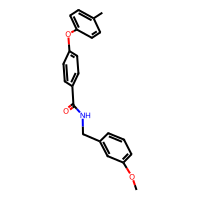
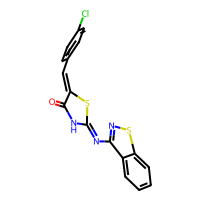
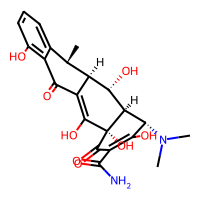
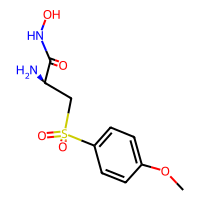
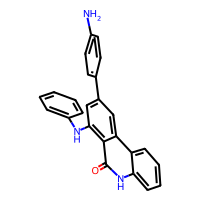
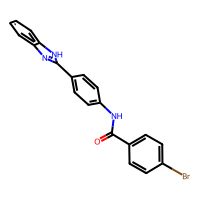
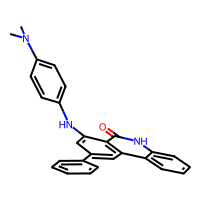
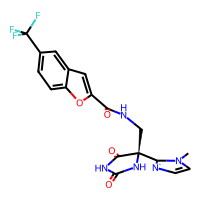
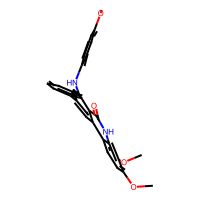
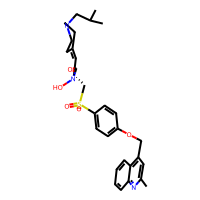
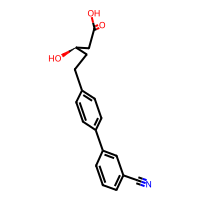
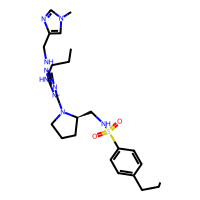
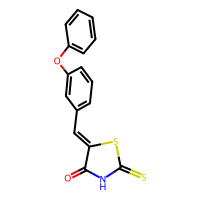
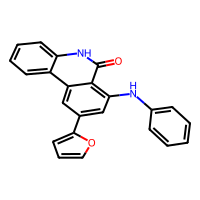
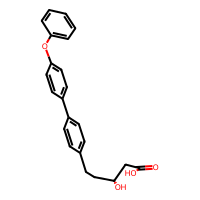
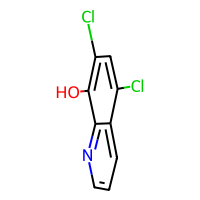
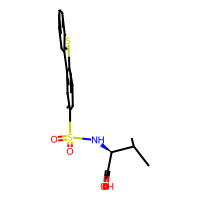
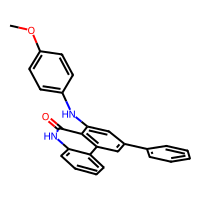
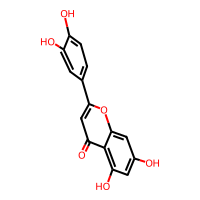
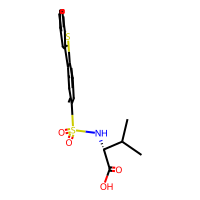
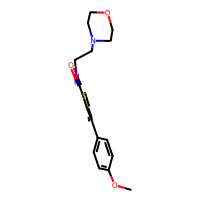
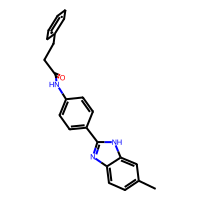
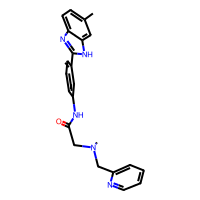
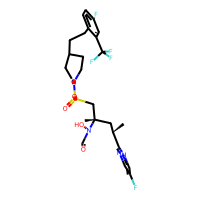
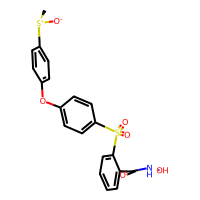
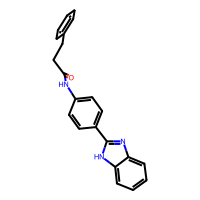
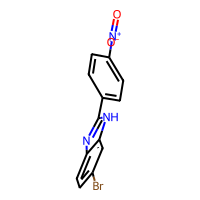
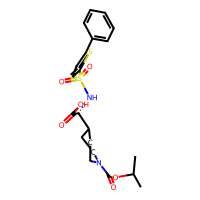
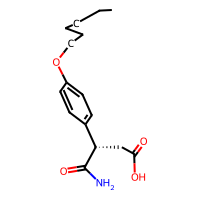
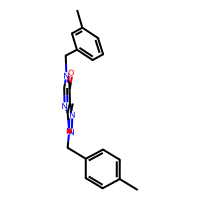
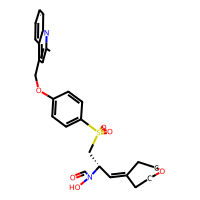
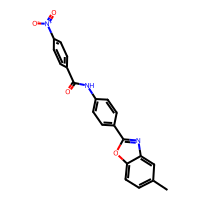
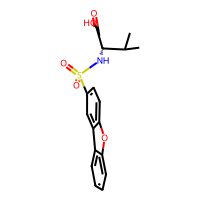
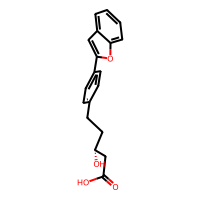
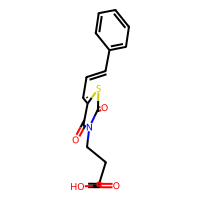
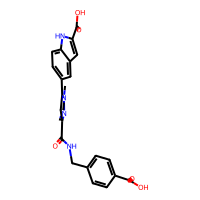
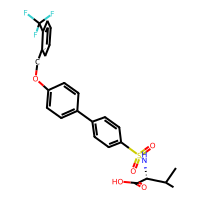
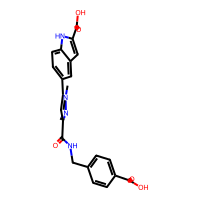
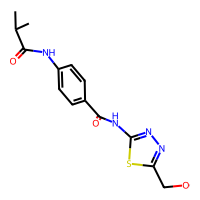
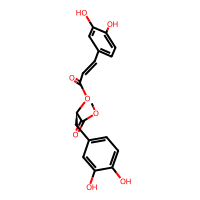
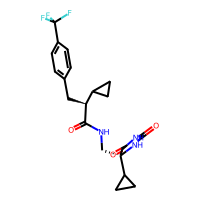
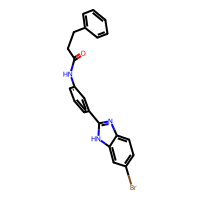
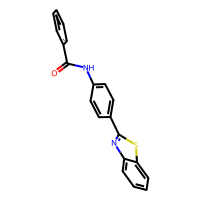
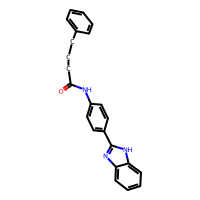
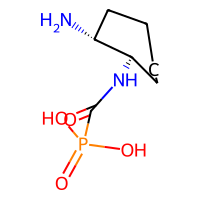
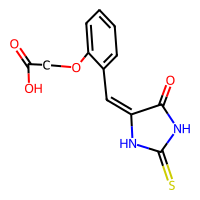
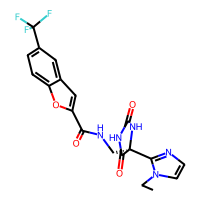
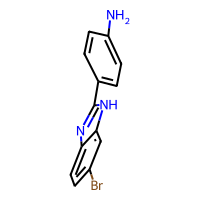
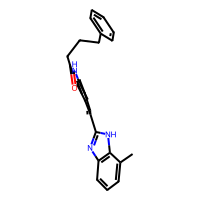
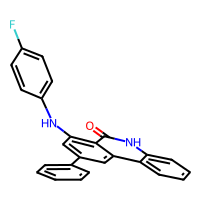
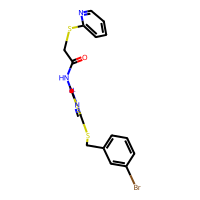
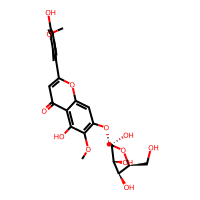
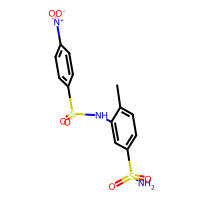
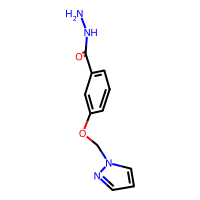
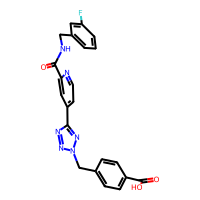

In [103]:
method_val_results = PandasTools.LoadSDF("method_validation_3KEJ_smina_results.sdf")

method_val_results

minimizedAffinity                ID  \
0          -12.29189     CHEMBL1796281   
1           -9.63010      CHEMBL263909   
2           -5.14956        CHEMBL1433   
3           -8.90048       CHEMBL90057   
4            0.60753     CHEMBL4800543   
5           -1.86817     CHEMBL4643922   
6            2.69896     CHEMBL4780502   
7           -9.59862     CHEMBL3358158   
8            6.99447     CHEMBL4753504   
9          -11.03642      CHEMBL318252   
10          -9.39077      CHEMBL574666   
11          -7.05743     CHEMBL2164094   
12         -10.45744      CHEMBL161669   
13          -1.85853     CHEMBL4742183   
14         -10.29584      CHEMBL575947   
15          -6.30735     CHEMBL1200596   
16          -9.43026      CHEMBL551190   
17          -2.74506     CHEMBL4756447   
18         -10.46855         CHEMBL151   
19          -9.09966      CHEMBL570310   
20          -9.41783      CHEMBL181682   
21         -10.29974     CHEMBL4640970   
22         -10.05175     CHEMBL4641067   
23          -9.39999     CHEMBL1683453   
24         -10.27226      CHEMBL576762   
25         -10.25113     CHEMBL4647266   
26          -8.31706     CHEMBL4635076   
27          -9.75429      CHEMBL468738   
28          -9.02022      CHEMBL448246   
29         -11.88402      CHEMBL473736   
30         -10.43196       CHEMBL99045   
31          -3.79715     CHEMBL4640215   
32          -9.71220      CHEMBL515439   
33         -10.24209      CHEMBL574444   
34          -8.75228     CHEMBL1927184   
35         -12.97207     CHEMBL1939879   
36         -10.87082     CHEMBL1910469   
37         -12.95646     CHEMBL1939879   
38          -8.31527      CHEMBL502936   
39         -11.68223      CHEMBL241405   
40          -9.40752     CHEMBL3980860   
41         -11.01029     CHEMBL4633399   
42          -8.94781      CHEMBL421666   
43         -10.85063     CHEMBL4634529   
44          -8.85440      CHEMBL270296   
45          -7.50989     CHEMBL1927185   
46          -9.04549     CHEMBL4450729   
47          -8.68739     CHEMBL4646265   
48         -10.73289     CHEMBL4644146   
49           2.70295     CHEMBL4777311   
50         -10.80353         ZINC62458   
51          -8.28979      ZINC12419118   
52          -9.21808       ZINC8399795   
53          -9.18991       ZINC2535232   
54         -14.53705  ZINC_mmp13ligand   

                                                ROMol  Binding_State  
0   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
1   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
2   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
3   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
4   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
5   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
6   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
7   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
8   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
9   <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
10  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
11  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
12  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
13  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
14  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
15  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
16  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
17  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
18  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
19  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
20  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
21  <rdkit.Chem.rdchem.Mol object at 0x0000011A903...              0  
22  <rdkit.Chem.r
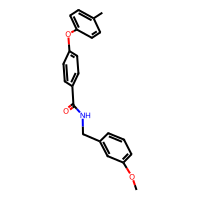
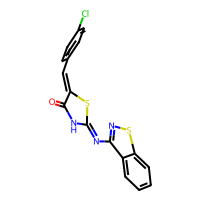
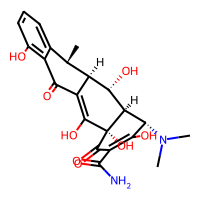
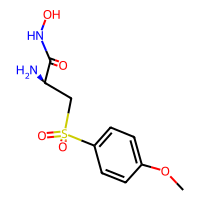
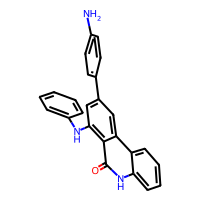
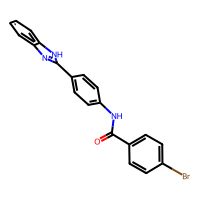
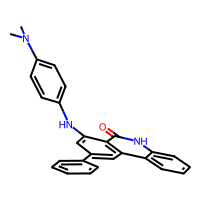
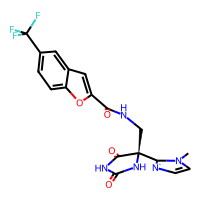
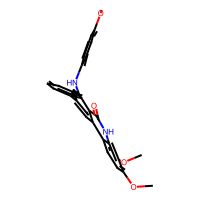
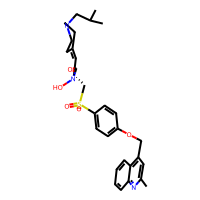
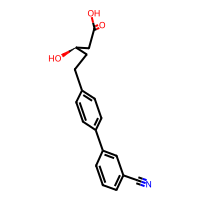
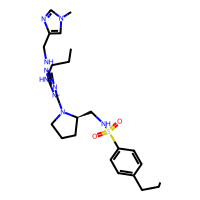
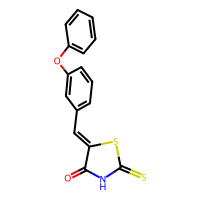
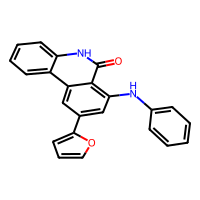
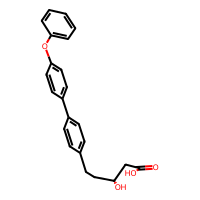
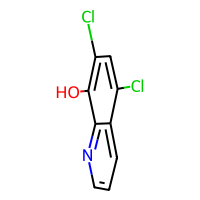
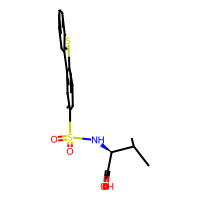
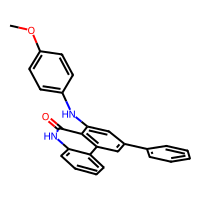
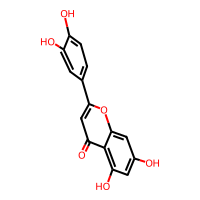
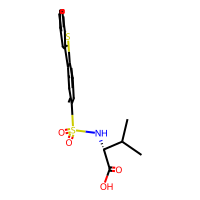
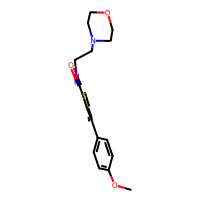
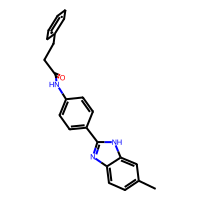
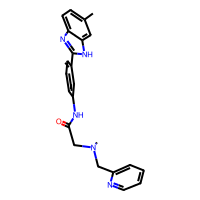
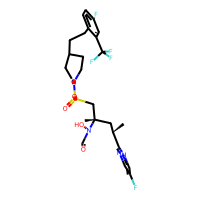
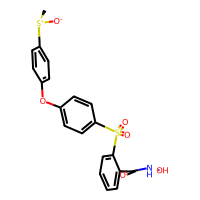
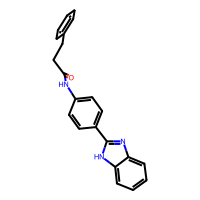
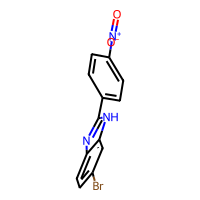
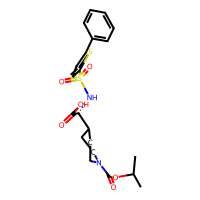
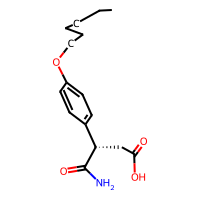
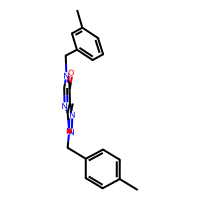
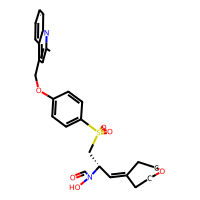
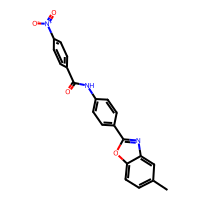
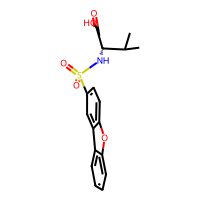
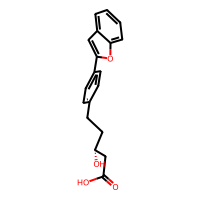
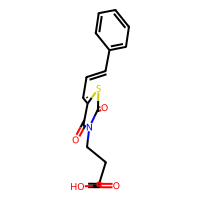
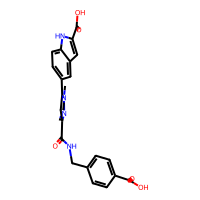
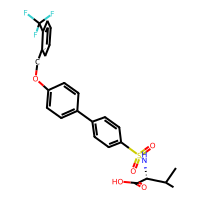
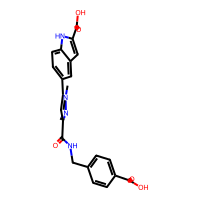
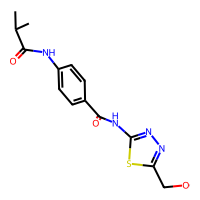
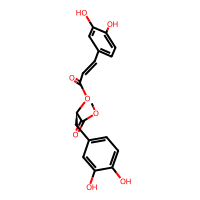
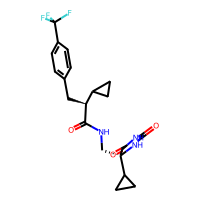
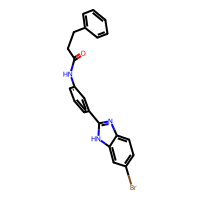
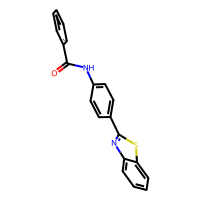
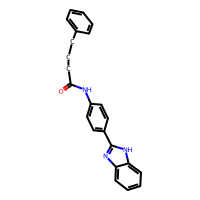
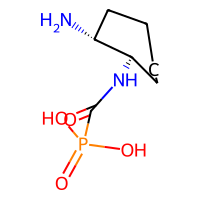
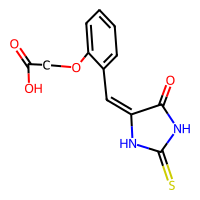
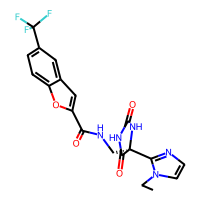
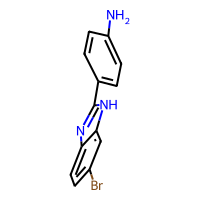
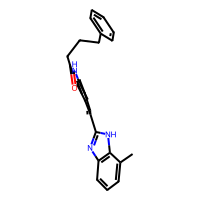
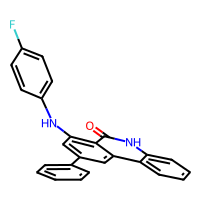
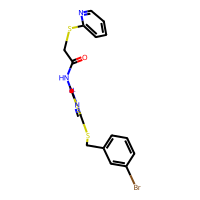
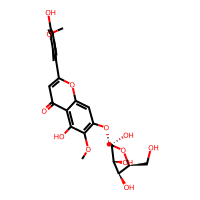
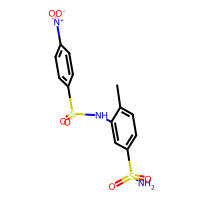
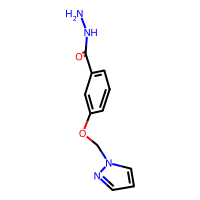
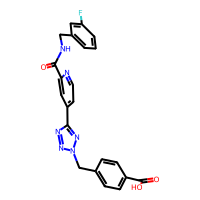

In [104]:
# Assign binary labels based on the ID prefix
method_val_results["Binding_State"] = method_val_results["ID"].apply(lambda x: 1 if x.startswith("ZINC") else 0)

# Display the updated DataFrame
method_val_results


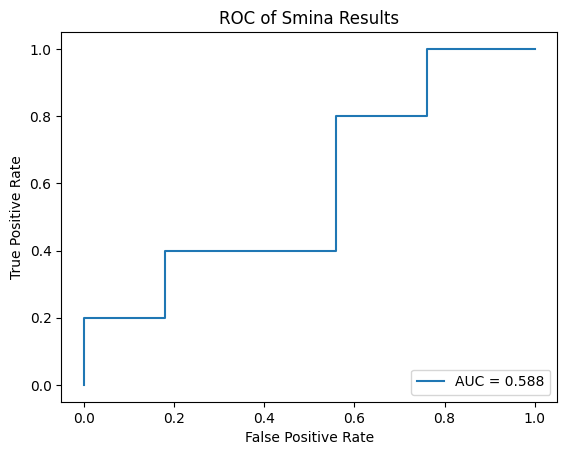

In [105]:
from sklearn import metrics
import matplotlib.pyplot as plt

# Convert minimizedAffinity to float (ensure correct data type)
method_val_results["minimizedAffinity"] = method_val_results["minimizedAffinity"].astype(float)

# Define True Positive (Binding_State) and Score (minimizedAffinity)
fpr, tpr, _ = metrics.roc_curve(method_val_results["Binding_State"], -method_val_results["minimizedAffinity"])
auc = metrics.roc_auc_score(method_val_results["Binding_State"], -method_val_results["minimizedAffinity"])

# Create ROC Curve Plot
plt.plot(fpr, tpr, label="AUC = " + str(round(auc, 3)))
plt.title("ROC of Smina Results")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)
plt.show()

In [123]:
cmd.get_names('all')

['3KEJ-receptor',
 '3KEJ-ligand',
 '3KEJ_smina_results',
 'pocketresidues',
 'MMP13_Ligand',
 'BRD-K52087522-300-01-2',
 'BRD-K00003255-001-01-9',
 'BRD-K00003140-001-01-9',
 'BRD-K89517477-001-01-4',
 'BRD-K92723993-001-12-5',
 'BRD-K39171998-001-01-1',
 'BRD-K55305701-001-02-0',
 'BRD-K71035033-001-07-1',
 'BRD-K84564571-001-03-9',
 'BRD-K16485616-001-13-9',
 'BRD-K48371964-001-06-5',
 'BRD-K00003315-001-01-9',
 'BRD-K00003304-001-01-9',
 'BRD-K00003234-001-01-9',
 'BRD-K84783599-001-01-0',
 'BRD-K48443249-001-01-0',
 'BRD-K60659193-001-02-8',
 'BRD-K97010173-001-06-9',
 'BRD-K31309378-001-02-3',
 'BRD-K00003209-001-01-9',
 'BRD-K56565215-001-01-9',
 'BRD-K97963946-001-01-3',
 'BRD-K23533833-001-01-9',
 'BRD-K55487946-001-01-3',
 'BRD-K83144676-001-09-5',
 'BRD-K00003219-001-01-9',
 'BRD-K54783522-001-01-8',
 'BRD-K49246350-001-01-1',
 'BRD-K54264768-001-01-2',
 'BRD-K88854110-001-01-5',
 'BRD-K78118466-001-03-3',
 'BRD-K16810791-001-01-0',
 'BRD-K30867024-003-03-3',
 'BRD-K00004238-